In [1]:
# Cell 1: Setup and Google Drive Access
import pandas as pd
import numpy as np
import glob
import requests
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully.")

Mounted at /content/drive
✅ Google Drive mounted successfully.


In [2]:
# Cell 2: Final, Corrected Data Consolidation

import pandas as pd
import glob

print("Starting robust data consolidation...")

# 1. Load raw data files
base_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/raw_data/"
slot_files_path = f"{base_path}/*_slot.csv"
site_files_path = f"{base_path}/*_site.csv"
slot_files = glob.glob(slot_files_path)
site_files = glob.glob(site_files_path)
df_slots = pd.concat((pd.read_csv(f, low_memory=False) for f in slot_files), ignore_index=True)
df_sites = pd.concat((pd.read_csv(f, low_memory=False) for f in site_files), ignore_index=True)

# 2. Prepare site data (for GEO info only)
site_info_cols = ['sno', 'latitude', 'longitude', 'sareaen']
df_sites_latest_info = df_sites.drop_duplicates(subset='sno', keep='last')[site_info_cols]
df_sites_latest_info.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)

# 3. Prepare slot data
df_slots.rename(columns={'infoTime': 'time'}, inplace=True)
df_slots['time'] = pd.to_datetime(df_slots['time'])

# 4. Perform a simple left merge
df_merged = pd.merge(df_slots, df_sites_latest_info, on='sno', how='left')

# 5. Select final columns
final_columns = ["time", "sno", "available_rent_bikes", "available_return_bikes", "total", "lat", "lng", "sareaen"]
df = df_merged[final_columns]

# 6. Final Cleaning and Verification
# First, fill any potential NaNs in 'total' that might come from the merge
df['total'] = df.groupby('sno')['total'].ffill().bfill()
df.dropna(subset=['total'], inplace=True) # Drop stations if total could not be filled

# *** THE KEY FIX IS HERE: Round 'total' and convert it to a whole number ***
df['total'] = df['total'].round().astype(int)

# Handle potential NaNs in other merged columns
geo_cols = ['lat', 'lng', 'sareaen']
if df[geo_cols].isnull().any().any():
    df[geo_cols] = df.groupby('sno')[geo_cols].ffill().bfill()
    df.dropna(inplace=True)

# *** ADD THIS FINAL SORTING STEP ***
print("\nSorting final DataFrame by station and time...")
df.sort_values(by=['sno', 'time'], inplace=True)
df.reset_index(drop=True, inplace=True) # Good practice to reset index after a final sort

print("\n✅ Robust consolidation complete.")

Starting robust data consolidation...

Sorting final DataFrame by station and time...

✅ Robust consolidation complete.


In [3]:
# Cell 3: Verification and Initial Filtering

# Verify data integrity
print("Verifying data integrity...")
is_unique = df.set_index(['time', 'sno']).index.is_unique
print(f"Are all (time, sno) combinations unique? {is_unique}\n")

# Filter the DataFrame to start from 2024-05-04
print(f"Original start time: {df['time'].min()}")
df = df[df['time'] >= '2024-05-04'].copy()
df.reset_index(drop=True, inplace=True)
print(f"✅ Data filtered. New start time: {df['time'].min()}")

# --- Check for Null Values ---

# 1. Get the total count of null (missing) values in each column
null_counts = df.isnull().sum()

print("✅ --- Null Value Count per Column ---")
print(null_counts)

# 2. Calculate the percentage of missing values, which is often more useful
total_rows = len(df)
if total_rows > 0:
    missing_percentage = (null_counts / total_rows) * 100
    print("\n\n📊 --- Missing Value Percentage per Column ---")
    print(missing_percentage)

Verifying data integrity...
Are all (time, sno) combinations unique? True

Original start time: 2024-05-03 18:50:28
✅ Data filtered. New start time: 2024-05-04 00:01:15
✅ --- Null Value Count per Column ---
time                      0
sno                       0
available_rent_bikes      0
available_return_bikes    0
total                     0
lat                       0
lng                       0
sareaen                   0
dtype: int64


📊 --- Missing Value Percentage per Column ---
time                      0.0
sno                       0.0
available_rent_bikes      0.0
available_return_bikes    0.0
total                     0.0
lat                       0.0
lng                       0.0
sareaen                   0.0
dtype: float64


In [4]:
# For each station, count how many unique values exist for 'total'
# If the count is greater than 1, it means the capacity changed at some point.
static_consistency = df.groupby('sno')['total'].nunique()
stations_with_changing_capacity = static_consistency[static_consistency > 1]

print(f"Number of stations with a changing total capacity: {len(stations_with_changing_capacity)}")

if len(stations_with_changing_capacity) > 0:
    print("\nStations with changing capacity:")
    print(stations_with_changing_capacity)

Number of stations with a changing total capacity: 445

Stations with changing capacity:
sno
500101003    2
500101006    2
500101015    2
500101019    2
500101026    2
            ..
500119081    2
500119084    2
500119086    2
500119088    3
500119090    2
Name: total, Length: 445, dtype: int64


In [5]:
# --- Corrected Verification Script ---

test_sno = 500101003
print(f"\n--- Verifying historical accuracy for station {test_sno} ---")

# Isolate all data for our test station
station_df = df[df['sno'] == test_sno].copy()

# *** THE KEY FIX IS HERE: Sort the data by time before checking for differences ***
station_df.sort_values(by='time', inplace=True)

# Find the exact rows where the 'total' value truly changes
change_points = station_df[station_df['total'].diff() != 0].iloc[1:]

# Display the data around the change point
if not change_points.empty:
    print(f"✅ Found {len(change_points)} true change(s) in capacity for this station.")
    print("Displaying data from just before and after the first change:")

    first_change_loc = station_df.index.get_loc(change_points.index[0])
    start_loc = max(0, first_change_loc - 5)
    end_loc = min(len(station_df), first_change_loc + 5)

    print(station_df.iloc[start_loc:end_loc][['time', 'sno', 'total']])

else:
    print(f"✅ No true capacity changes found for station {test_sno}.")


--- Verifying historical accuracy for station 500101003 ---
✅ Found 1 true change(s) in capacity for this station.
Displaying data from just before and after the first change:
                      time        sno  total
108898 2025-04-21 09:39:15  500101003     16
108899 2025-04-21 10:20:04  500101003     16
108900 2025-04-21 13:00:03  500101003     16
108901 2025-04-21 13:26:01  500101003     16
108902 2025-04-21 13:30:04  500101003     16
108903 2025-04-21 13:40:05  500101003     28
108904 2025-04-21 13:53:16  500101003     28
108905 2025-04-21 14:17:14  500101003     28
108906 2025-04-21 14:20:04  500101003     28
108907 2025-04-21 21:10:03  500101003     28


In [6]:
# Save to a compressed Parquet file for better performance
output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/complete_ubike_raw.parquet.gz"
df.to_parquet(output_path, compression='gzip')

print(f"\nData consolidated and saved to: {output_path}")
print("Final DataFrame shape:", df.shape)
print("Data head:")
print(df.head())
print(df.tail())


Data consolidated and saved to: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/complete_bike_data.parquet.gz
Final DataFrame shape: (41136365, 8)
Data head:
                 time        sno  available_rent_bikes  \
0 2024-05-04 00:06:17  500101001                     6   
1 2024-05-04 00:18:18  500101001                     3   
2 2024-05-04 00:28:17  500101001                     2   
3 2024-05-04 00:30:44  500101001                     0   
4 2024-05-04 00:47:18  500101001                     1   

   available_return_bikes  total       lat       lng     sareaen  
0                      22     28  25.02605  121.5436  Daan Dist.  
1                      25     28  25.02605  121.5436  Daan Dist.  
2                      26     28  25.02605  121.5436  Daan Dist.  
3                      28     28  25.02605  121.5436  Daan Dist.  
4                      27     28  25.02605  121.5436  Daan Dist.  
                        time        sno  available_rent_bikes  

In [7]:
# Define the path to your consolidated Parquet file
#file_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/complete_ubike_raw.parquet.gz"

# Read the data into a pandas DataFrame
#df = pd.read_parquet(file_path)

# Cell 4: Final Memory-Safe Scaffolding (Corrected)

import numpy as np
import pandas as pd

# --- Pre-computation (done once) ---
print("Preparing lookup tables and global time range...")

# 1. Create the "source of truth" lookup table of all true active days
df['date'] = pd.to_datetime(df['time']).dt.date
true_active_days = df[['sno', 'date']].drop_duplicates()
true_active_days_lookup = pd.MultiIndex.from_frame(true_active_days)
print(f"✅ Created a lookup table with {len(true_active_days)} unique station-day combinations.")

# 2. Define the full global time range
start_date = df['time'].min().floor('D')
end_date = df['time'].max().ceil('D') - pd.Timedelta(minutes=10)
full_range = pd.date_range(start=start_date, end=end_date, freq='10min')

# --- Station-by-Station Processing ---
processed_stations = []
all_stations = df['sno'].unique()
total_stations = len(all_stations)

print(f"\nProcessing {total_stations} stations one by one (this may take some time)...")

# 3. Loop through each station's data
for i, sno in enumerate(all_stations):
    if (i + 1) % 100 == 0: # Print progress every 100 stations
        print(f"  Processed {i + 1} / {total_stations} stations...")

    station_df = df[df['sno'] == sno]

    # A. Create a scaffold FOR THIS STATION ONLY
    station_scaffold = pd.DataFrame({'time': full_range, 'sno': sno})

    # B. Tag this scaffold's days as active/inactive using the lookup table
    station_scaffold['date'] = station_scaffold['time'].dt.date
    scaffold_days_index = pd.MultiIndex.from_frame(station_scaffold[['sno', 'date']])
    station_scaffold['act'] = scaffold_days_index.isin(true_active_days_lookup).astype(int)

    # C. Prepare this station's real data by rounding time
    station_rounded = station_df.copy()
    station_rounded['time_rounded'] = station_rounded['time'].dt.round('10min')

    # D. Merge the station's scaffold with its real data
    station_gapped = pd.merge(
        station_scaffold,
        station_rounded.drop(columns=['date']),
        left_on=['sno', 'time'],
        right_on=['sno', 'time_rounded'],
        how='left'
    )

    # E. Clean up the merge
    # *** THE FIX IS HERE: Use the renamed column 'time_x' ***
    station_gapped = station_gapped.drop_duplicates(subset=['sno', 'time_x'], keep='last')
    station_gapped = station_gapped.drop(columns=['time_y', 'time_rounded'], errors='ignore').rename(columns={'time_x': 'time'})

    # F. Impute values based on 'act' status
    dynamic_cols = ['available_rent_bikes', 'available_return_bikes']
    active_rows_mask = station_gapped['act'] == 1
    station_gapped.loc[active_rows_mask, dynamic_cols] = station_gapped[active_rows_mask].groupby('date')[dynamic_cols].ffill().bfill()

    inactive_rows_mask = station_gapped['act'] == 0
    station_gapped.loc[inactive_rows_mask, dynamic_cols] = -1

    static_cols = ['total', 'lat', 'lng', 'sareaen']
    station_gapped[static_cols] = station_gapped[static_cols].ffill().bfill()

    # G. Append the fully processed station to the list
    processed_stations.append(station_gapped.drop(columns='date'))

# 4. Combine all processed stations into one final DataFrame
print("\nCombining all processed stations...")
df_scaffolded = pd.concat(processed_stations, ignore_index=True)

print("✅ Scaffolding complete (memory-safe).")

# Final check for any remaining nulls
print("\nNull values remaining:")
print(df_scaffolded.isnull().sum())

print("\nFinal Data Head:")
print(df_scaffolded.head())

Preparing lookup tables and global time range...
✅ Created a lookup table with 612177 unique station-day combinations.

Processing 1613 stations one by one (this may take some time)...
  Processed 100 / 1613 stations...
  Processed 200 / 1613 stations...
  Processed 300 / 1613 stations...
  Processed 400 / 1613 stations...
  Processed 500 / 1613 stations...
  Processed 600 / 1613 stations...
  Processed 700 / 1613 stations...
  Processed 800 / 1613 stations...
  Processed 900 / 1613 stations...
  Processed 1000 / 1613 stations...
  Processed 1100 / 1613 stations...
  Processed 1200 / 1613 stations...
  Processed 1300 / 1613 stations...
  Processed 1400 / 1613 stations...
  Processed 1500 / 1613 stations...
  Processed 1600 / 1613 stations...

Combining all processed stations...
✅ Scaffolding complete (memory-safe).

Null values remaining:
time                      0
sno                       0
act                       0
available_rent_bikes      0
available_return_bikes    0
total    

In [8]:
# Save to a compressed Parquet file for better performance
output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_prep_step1.parquet.gz"
df_scaffolded.to_parquet(output_path, compression='gzip')

print(f"\nData consolidated and saved to: {output_path}")
print("Final DataFrame shape:", df_scaffolded.shape)
print("Data head:")
print(df_scaffolded.head())
print(df_scaffolded.tail())


Data consolidated and saved to: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/complete_bike_data_resampled.parquet.gz
Final DataFrame shape: (96392880, 9)
Data head:
                 time        sno  act  available_rent_bikes  \
0 2024-05-04 00:00:00  500101001    1                   6.0   
1 2024-05-04 00:10:00  500101001    1                   6.0   
2 2024-05-04 00:20:00  500101001    1                   3.0   
3 2024-05-04 00:30:00  500101001    1                   0.0   
4 2024-05-04 00:40:00  500101001    1                   0.0   

   available_return_bikes  total       lat       lng     sareaen  
0                    22.0   28.0  25.02605  121.5436  Daan Dist.  
1                    22.0   28.0  25.02605  121.5436  Daan Dist.  
2                    25.0   28.0  25.02605  121.5436  Daan Dist.  
3                    28.0   28.0  25.02605  121.5436  Daan Dist.  
4                    28.0   28.0  25.02605  121.5436  Daan Dist.  
                       

In [2]:
# Define the path to your consolidated_resampled Parquet file
file_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_prep_step1.parquet.gz"

# Read the data into a pandas DataFrame
df_scaffolded = pd.read_parquet(file_path)

In [3]:
# Count the occurrences of each value in the 'act' column
activity_counts = df_scaffolded['act'].value_counts()

print("✅ Record Counts by Activity Status:")
print(activity_counts)

✅ Record Counts by Activity Status:
act
1    88153488
0     8239392
Name: count, dtype: int64


In [3]:
# Cell A: (Run Once) Fetch and Save API Station List

import pandas as pd
import requests

API_URL = "https://tcgbusfs.blob.core.windows.net/dotapp/youbike/v2/youbike_immediate.json"
API_STATIONS_FILE_PATH = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/youbike_api_stations.csv"

try:
    print("Fetching station list from live API...")
    response = requests.get(API_URL)
    response.raise_for_status()
    api_data = response.json()
    df_api = pd.DataFrame(api_data)

    # Select and clean the data you want to save
    df_to_save = df_api[['sno', 'snaen']].copy()
    df_to_save['sno'] = pd.to_numeric(df_to_save['sno'], errors='coerce')

    # Save to a CSV file
    df_to_save.to_csv(API_STATIONS_FILE_PATH, index=False)

    print(f"✅ Successfully fetched and saved {len(df_to_save)} stations to:")
    print(API_STATIONS_FILE_PATH)

except requests.exceptions.RequestException as e:
    print(f"❌ Error fetching API data: {e}. Please try again later when the API is stable.")

Fetching station list from live API...
✅ Successfully fetched and saved 1652 stations to:
/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/youbike_api_stations.csv


In [4]:
# Cell B: Enrich Data from Saved File

import pandas as pd

API_STATIONS_FILE_PATH = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/youbike_api_stations.csv"

print("Enriching data with English station names from the saved file...")

try:
    # 1. Load the reliable station list from your saved file
    df_station_names = pd.read_csv(API_STATIONS_FILE_PATH)
    print(f"✅ Successfully loaded {len(df_station_names)} stations from the file.")

    # 2. Perform a LEFT merge to add names without deleting stations yet
    stations_before_merge = df_scaffolded['sno'].nunique()
    df_enriched_temp = pd.merge(df_scaffolded, df_station_names, on='sno', how='left')

    # 3. Identify and report the stations that were not found
    stations_not_found_mask = df_enriched_temp['snaen'].isnull()
    stations_to_drop = df_enriched_temp[stations_not_found_mask]['sno'].unique()

    if len(stations_to_drop) > 0:
        print(f"\nFound {len(stations_to_drop)} stations in your historical data that are not in the API list.")
        print("These stations will be removed.")

    # 4. Filter out the unfound stations to create the final DataFrame
    df_enriched = df_enriched_temp.dropna(subset=['snaen']).copy()

    stations_after_filter = df_enriched['sno'].nunique()
    stations_removed = stations_before_merge - stations_after_filter

    print(f"\nStations in your dataset before filtering: {stations_before_merge}")
    print(f"Stations in your dataset after filtering: {stations_after_filter} ({stations_removed} removed)")

    print("\n✅ Enrichment and filtering complete.")
    print("Data head:")
    print(df_enriched.head())

except FileNotFoundError:
    print(f"❌ Error: The file {API_STATIONS_FILE_PATH} was not found.")
    print("Please run the 'Fetch and Save API' script first when the API is stable.")
    df_enriched = df_scaffolded.copy()

Enriching data with English station names from the saved file...
✅ Successfully loaded 1652 stations from the file.

Found 6 stations in your historical data that are not in the API list.
These stations will be removed.

Stations in your dataset before filtering: 1613
Stations in your dataset after filtering: 1607 (6 removed)

✅ Enrichment and filtering complete.
Data head:
                 time        sno  act  available_rent_bikes  \
0 2024-05-04 00:00:00  500101001    1                   6.0   
1 2024-05-04 00:10:00  500101001    1                   6.0   
2 2024-05-04 00:20:00  500101001    1                   3.0   
3 2024-05-04 00:30:00  500101001    1                   0.0   
4 2024-05-04 00:40:00  500101001    1                   0.0   

   available_return_bikes  total       lat       lng     sareaen  \
0                    22.0   28.0  25.02605  121.5436  Daan Dist.   
1                    22.0   28.0  25.02605  121.5436  Daan Dist.   
2                    25.0   28.0  25.026

In [5]:
# 1. Get the set of station IDs BEFORE the merge
stations_before = set(df_scaffolded['sno'].unique())

# 2. Get the set of station IDs AFTER the merge
stations_after = set(df_enriched['sno'].unique())

# 3. Find the difference between the two sets
dropped_station_ids = stations_before - stations_after

print(f"✅ Found {len(dropped_station_ids)} dropped stations.")

if dropped_station_ids:
    print("The following station IDs were dropped:")
    # Print the list of dropped IDs
    print(list(dropped_station_ids))

✅ Found 6 dropped stations.
The following station IDs were dropped:
[np.int64(500107074), np.int64(500108130), np.int64(500107057), np.int64(500105052), np.int64(500106141), np.int64(500101183)]


In [6]:
# This assumes your 'df_enriched' DataFrame is already loaded in memory.

# 1. Remove the "YouBike2.0_" prefix from the 'snaen' column
print("Cleaning the 'snaen' column...")
df_enriched['snaen'] = df_enriched['snaen'].str.replace('YouBike2.0_', '', regex=False)

print("✅ Prefix removed. Here's a sample of the cleaned names:")
print(df_enriched[['sno', 'snaen']].head())


# 2. Perform a final check for any missing data
print("\n\n--- Final Missing Data Check ---")
missing_data_check = df_enriched.isnull().sum()
print(missing_data_check)

# Check if the total number of missing values is zero
if missing_data_check.sum() == 0:
    print("\n✅ Verification successful. No missing data found in the final dataset.")
else:
    print("\n❌ Warning: Missing data was found. Please review the counts above.")

Cleaning the 'snaen' column...
✅ Prefix removed. Here's a sample of the cleaned names:
         sno                      snaen
0  500101001  MRT Technology Bldg. Sta.
1  500101001  MRT Technology Bldg. Sta.
2  500101001  MRT Technology Bldg. Sta.
3  500101001  MRT Technology Bldg. Sta.
4  500101001  MRT Technology Bldg. Sta.


--- Final Missing Data Check ---
time                      0
sno                       0
act                       0
available_rent_bikes      0
available_return_bikes    0
total                     0
lat                       0
lng                       0
sareaen                   0
snaen                     0
dtype: int64

✅ Verification successful. No missing data found in the final dataset.


In [7]:
# Save to a compressed enriched Parquet file for better performance
output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/complete_bike_data_enriched.parquet.gz"
df_enriched.to_parquet(output_path, compression='gzip')

print(f"\nData enriched and saved to: {output_path}")
print("Final DataFrame shape:", df_enriched.shape)
print("Data head:")
print(df_enriched.head())
print(df_enriched.tail())


Data consolidated, resampled and filtered and saved to: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/complete_bike_data_enriched.parquet.gz
Final DataFrame shape: (96034320, 10)
Data head:
                 time        sno  act  available_rent_bikes  \
0 2024-05-04 00:00:00  500101001    1                   6.0   
1 2024-05-04 00:10:00  500101001    1                   6.0   
2 2024-05-04 00:20:00  500101001    1                   3.0   
3 2024-05-04 00:30:00  500101001    1                   0.0   
4 2024-05-04 00:40:00  500101001    1                   0.0   

   available_return_bikes  total       lat       lng     sareaen  \
0                    22.0   28.0  25.02605  121.5436  Daan Dist.   
1                    22.0   28.0  25.02605  121.5436  Daan Dist.   
2                    25.0   28.0  25.02605  121.5436  Daan Dist.   
3                    28.0   28.0  25.02605  121.5436  Daan Dist.   
4                    28.0   28.0  25.02605  121.5436  Daan Di

In [2]:
# Define the path to your enriched Parquet file
file_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_prep_step2.parquet.gz"

# Read the data into a pandas DataFrame
df_enriched = pd.read_parquet(file_path)

--- Starting Station Activity Analysis ---

Analyzing a total of 1607 stations.

Activity Ratio statistics (All Stations):
count    1607.000000
mean        0.916691
std         0.216770
min         0.007229
25%         0.990361
50%         0.995181
75%         0.997590
max         1.000000
Name: activity_ratio, dtype: float64


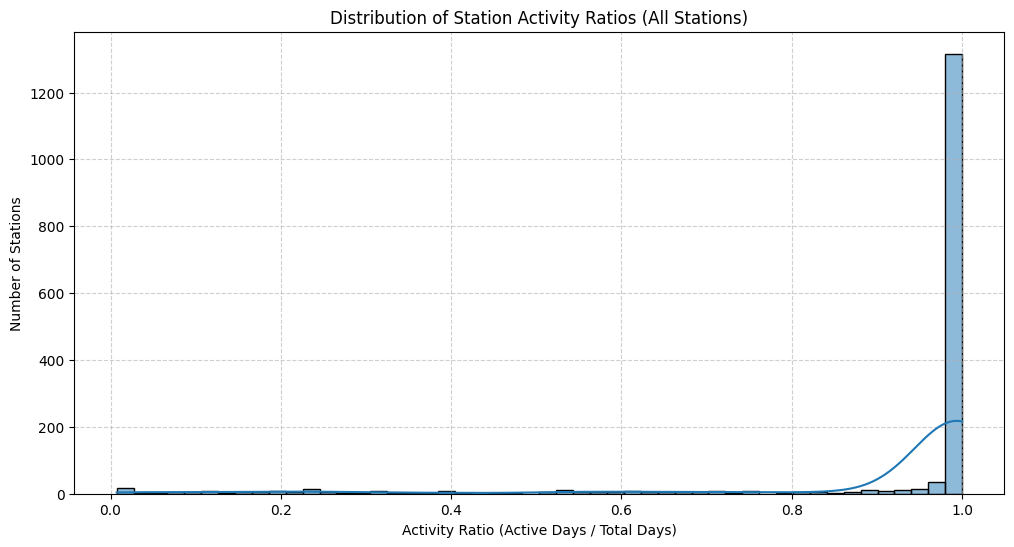


--- Analysis for >= 95.0% Activity ---
Number of stations kept: 1359 (248 dropped)
Statistics:
count    1359.000000
mean        0.994131
std         0.005776
min         0.951807
25%         0.992771
50%         0.995181
75%         0.997590
max         1.000000
Name: activity_ratio, dtype: float64


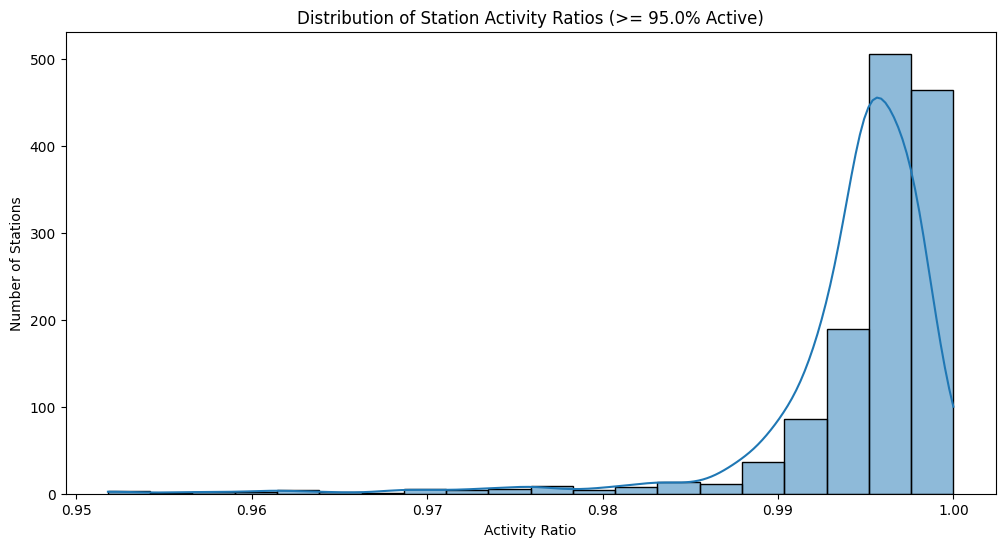


--- Analysis for >= 99.0% Activity ---
Number of stations kept: 1246 (361 dropped)
Statistics:
count    1246.000000
mean        0.995484
std         0.002309
min         0.990361
25%         0.995181
50%         0.995181
75%         0.997590
max         1.000000
Name: activity_ratio, dtype: float64


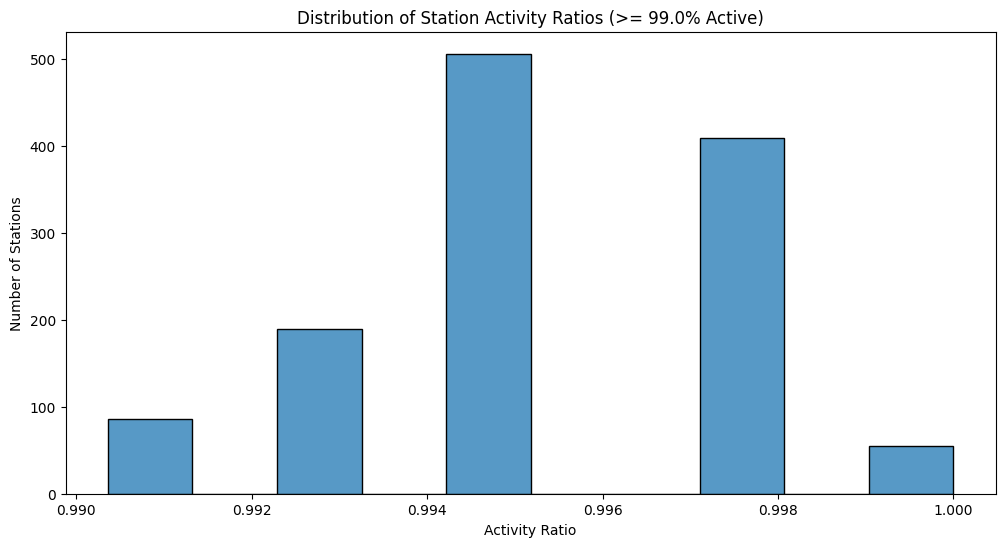


✅ Dataset filtered. Final station count: 1246 (361 stations with <99% activity were removed).


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Station Activity Analysis ---")

# --- 1. Calculate the Definitive Activity Report ---
df_enriched['date'] = pd.to_datetime(df_enriched['time']).dt.date

daily_status = df_enriched.groupby(['sno', 'date'])['act'].max().reset_index()
station_activity_summary = daily_status.groupby('sno')['act'].value_counts().unstack(fill_value=0)

if 0 not in station_activity_summary.columns: station_activity_summary[0] = 0
if 1 not in station_activity_summary.columns: station_activity_summary[1] = 0
station_activity_summary.rename(columns={0: 'inactive_days', 1: 'active_days'}, inplace=True)

station_activity_summary['total_days'] = station_activity_summary['active_days'] + station_activity_summary['inactive_days']
station_activity_summary['activity_ratio'] = station_activity_summary['active_days'] / station_activity_summary['total_days']

total_stations = len(station_activity_summary)
print(f"\nAnalyzing a total of {total_stations} stations.")
print("\nActivity Ratio statistics (All Stations):")
print(station_activity_summary['activity_ratio'].describe())


# --- 2. Visualize the Distribution for ALL Stations ---
plt.figure(figsize=(12, 6))
sns.histplot(station_activity_summary['activity_ratio'], bins=50, kde=True)
plt.title('Distribution of Station Activity Ratios (All Stations)')
plt.xlabel('Activity Ratio (Active Days / Total Days)')
plt.ylabel('Number of Stations')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# --- 3. Analyze and Visualize at the 95% Threshold ---
threshold_95 = 0.95
stations_over_95 = station_activity_summary[station_activity_summary['activity_ratio'] >= threshold_95]
stations_dropped_95 = total_stations - len(stations_over_95)
print(f"\n--- Analysis for >= {threshold_95*100}% Activity ---")
print(f"Number of stations kept: {len(stations_over_95)} ({stations_dropped_95} dropped)")
print("Statistics:")
print(stations_over_95['activity_ratio'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(stations_over_95['activity_ratio'], bins=20, kde=True)
plt.title(f'Distribution of Station Activity Ratios (>= {threshold_95*100}% Active)')
plt.xlabel('Activity Ratio')
plt.ylabel('Number of Stations')
plt.show()


# --- 4. Analyze and Visualize at the 99% Threshold ---
threshold_99 = 0.99
stations_over_99 = station_activity_summary[station_activity_summary['activity_ratio'] >= threshold_99]
stations_dropped_99 = total_stations - len(stations_over_99)
print(f"\n--- Analysis for >= {threshold_99*100}% Activity ---")
print(f"Number of stations kept: {len(stations_over_99)} ({stations_dropped_99} dropped)")
print("Statistics:")
print(stations_over_99['activity_ratio'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(stations_over_99['activity_ratio'], bins=10, kde=False)
plt.title(f'Distribution of Station Activity Ratios (>= {threshold_99*100}% Active)')
plt.xlabel('Activity Ratio')
plt.ylabel('Number of Stations')
plt.show()


# --- 5. Final Filtering ---
highly_active_station_ids = stations_over_99.index
df_filtered = df_enriched[df_enriched['sno'].isin(highly_active_station_ids)].copy()

print(f"\n✅ Dataset filtered. Final station count: {df_filtered['sno'].nunique()} ({stations_dropped_99} stations with <99% activity were removed).")

In [4]:
# Save to a compressed Parquet file for better performance
output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_prep_step3.parquet.gz"
df_filtered.to_parquet(output_path, compression='gzip')

print(f"\nData consolidated, resampled and filtered and saved to: {output_path}")
print("Final DataFrame shape:", df_filtered.shape)
print("Data head:")
print(df_filtered.head())
print(df_filtered.tail())


Data consolidated, resampled and filtered and saved to: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/complete_bike_data_resampled_and_filtered.parquet.gz
Final DataFrame shape: (74460960, 11)
Data head:
                 time        sno  act  available_rent_bikes  \
0 2024-05-04 00:00:00  500101001    1                   6.0   
1 2024-05-04 00:10:00  500101001    1                   6.0   
2 2024-05-04 00:20:00  500101001    1                   3.0   
3 2024-05-04 00:30:00  500101001    1                   0.0   
4 2024-05-04 00:40:00  500101001    1                   0.0   

   available_return_bikes  total       lat       lng     sareaen  \
0                    22.0   28.0  25.02605  121.5436  Daan Dist.   
1                    22.0   28.0  25.02605  121.5436  Daan Dist.   
2                    25.0   28.0  25.02605  121.5436  Daan Dist.   
3                    28.0   28.0  25.02605  121.5436  Daan Dist.   
4                    28.0   28.0  25.02605  121

In [5]:
# --- Data Integrity Verification ---

print("Verifying data integrity...")

# Test 1: Check if any inactive records (act=0) have bike counts NOT equal to -1.
# The result should be 0.
inactive_errors = len(df_filtered[
    (df_filtered['act'] == 0) &
    ((df_filtered['available_rent_bikes'] != -1) | (df_filtered['available_return_bikes'] != -1))
])

print(f"\nNumber of inactive records where bike counts are NOT -1: {inactive_errors}")


# Test 2: Check if any active records (act=1) have bike counts equal to -1.
# The result should be 0.
active_errors = len(df_filtered[
    (df_filtered['act'] == 1) &
    ((df_filtered['available_rent_bikes'] == -1) | (df_filtered['available_return_bikes'] == -1))
])

print(f"Number of active records where bike counts ARE -1: {active_errors}")

# --- Final Verdict ---
if inactive_errors == 0 and active_errors == 0:
    print("\n\n✅ Verification successful. The data is consistent.")
else:
    print("\n\n❌ Verification failed. Please review the counts above.")

Verifying data integrity...

Number of inactive records where bike counts are NOT -1: 0
Number of active records where bike counts ARE -1: 0


✅ Verification successful. The data is consistent.


In [6]:
# --- Final Verification ---
print("\nVerifying final data... Checking for any remaining null values:")
print(df_filtered.isnull().sum())

print("\n--- Final Processed Data ---")
print("Displaying a slice of data for a single station to show the filled values:")
# Display a sample where we can see a transition from active (1) to inactive (0) if possible
example_sno = df_filtered['sno'].iloc[0]
print(df_filtered[df_filtered['sno'] == example_sno].head(20))




Verifying final data... Checking for any remaining null values:
time                      0
sno                       0
act                       0
available_rent_bikes      0
available_return_bikes    0
total                     0
lat                       0
lng                       0
sareaen                   0
snaen                     0
date                      0
dtype: int64

--- Final Processed Data ---
Displaying a slice of data for a single station to show the filled values:
                  time        sno  act  available_rent_bikes  \
0  2024-05-04 00:00:00  500101001    1                   6.0   
1  2024-05-04 00:10:00  500101001    1                   6.0   
2  2024-05-04 00:20:00  500101001    1                   3.0   
3  2024-05-04 00:30:00  500101001    1                   0.0   
4  2024-05-04 00:40:00  500101001    1                   0.0   
5  2024-05-04 00:50:00  500101001    1                   0.0   
6  2024-05-04 01:00:00  500101001    1                   0.0 

In [3]:
# This assumes your 'df_filtered' DataFrame is loaded in memory.

# Create a DataFrame of only the active records for this check
df_active = df_filtered[df_filtered['act'] == 1].copy()

# Check for impossible values
print("--- Sanity Checks: Identifying Impossible Values ---")
impossible_rentals = df_active[df_active['available_rent_bikes'] > df_active['total']]
print(f"Number of records with more bikes than total docks: {len(impossible_rentals)}")

impossible_returns = df_active[df_active['available_return_bikes'] > df_active['total']]
print(f"Number of records with more return docks than total docks: {len(impossible_returns)}")

negative_bikes = df_active[df_active['available_rent_bikes'] < 0]
print(f"Number of active records with negative bike counts: {len(negative_bikes)}")

--- Sanity Checks: Identifying Impossible Values ---
Number of records with more bikes than total docks: 2
Number of records with more return docks than total docks: 133
Number of active records with negative bike counts: 0


In [7]:
# Save the final, processed data
final_output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_prep_step4.parquet.gz"
df_filtered.to_parquet(final_output_path, compression='gzip')
print(f"\nFinal processed data saved to: {final_output_path}")


Final processed data saved to: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/final_processed_data.parquet.gz


In [2]:
import pandas as pd

# ---- 1. Define the path to your Parquet file
# Make sure this is the correct source file you intend to use.
file_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_prep_step4.parquet.gz"

# Define ONLY the columns you need for your analysis.
# By not including 'date' here, you are effectively dropping it before it's even loaded.
columns_to_load = [
    'sno',
    'time',
    'act',
    'total',
    'available_rent_bikes',
    'available_return_bikes'
]

print(f"Selectively loading {len(columns_to_load)} columns from '{file_path}'...")

# Read only the specified columns into the DataFrame.
# This is much more memory-efficient than loading everything first.
df_subset = pd.read_parquet(file_path, columns=columns_to_load)

print("\n✅ Data loaded successfully with only the required columns.")
print("Final DataFrame columns:", df_subset.columns.tolist())

Selectively loading 6 columns from '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/almost_final_processed_data.parquet.gz'...

✅ Data loaded successfully with only the required columns.
Final DataFrame columns: ['sno', 'time', 'act', 'total', 'available_rent_bikes', 'available_return_bikes']


In [3]:
# Cell: Enhanced Outlier Detection with Data Classification

import numpy as np
import pandas as pd

# --- 2. Correct Impossible Values (The Missing Logic) ---
print("\nCorrecting impossible values (e.g., bikes > total capacity)...")

# Create a mask for active records to ensure we don't change our -1 placeholders
active_mask_full = df_subset['act'] == 1

# Get the indices of the rows that are active
active_indices = df_subset[active_mask_full].index

# Efficiently cap 'available_rent_bikes' and 'available_return_bikes' at the 'total'
# This is much faster than using .apply()
df_subset.loc[active_indices, 'available_rent_bikes'] = np.minimum(
    df_subset.loc[active_indices, 'available_rent_bikes'],
    df_subset.loc[active_indices, 'total']
)
df_subset.loc[active_indices, 'available_return_bikes'] = np.minimum(
    df_subset.loc[active_indices, 'available_return_bikes'],
    df_subset.loc[active_indices, 'total']
)

# Also ensure no active bike counts are negative
df_subset.loc[active_indices, 'available_rent_bikes'] = df_subset.loc[active_indices, 'available_rent_bikes'].clip(lower=0)
df_subset.loc[active_indices, 'available_return_bikes'] = df_subset.loc[active_indices, 'available_return_bikes'].clip(lower=0)


print("✅ Impossible values corrected.")


# --- 3. Classify the Data ---
print("\nClassifying data by hour and day type (Weekday/Weekend)...")
df_subset['hour'] = pd.to_datetime(df_subset['time']).dt.hour
df_subset['is_weekday'] = pd.to_datetime(df_subset['time']).dt.dayofweek < 5


# --- 4. Statistical Outlier Detection within each Class ---
# p: The lookback period. Since we group by hour, p=7 means the last 7 instances of that specific hour.
p_window = 7
# ε: The standard deviation threshold.
epsilon = 3.0
cols_to_check = ['available_rent_bikes', 'available_return_bikes']

print(f"\n--- Identifying Statistical Outliers (p={p_window} occurrences, ε={epsilon}) ---")

# We create a new DataFrame to store the cleaned results
df_cleaned_subset = df_subset.copy()

for col in cols_to_check:
    print(f"Processing column: {col}...")
    # Group by station, day type, AND hour for a much more accurate comparison
    grouped = df_subset[df_subset['act'] == 1].groupby(['sno', 'is_weekday', 'hour'])[col]

    # Calculate rolling stats within these highly specific groups
    rolling_avg = grouped.transform(lambda x: x.rolling(window=p_window, min_periods=1).mean())
    rolling_std = grouped.transform(lambda x: x.rolling(window=p_window, min_periods=1).std()).fillna(0)

    # Calculate the score only for active records
    # We need to align the indices for the calculation to work correctly
    active_subset = df_subset.loc[active_mask_full, col]
    score = (active_subset - rolling_avg) / rolling_std
    score.replace([np.inf, -np.inf], 0, inplace=True) # Handle division by zero

    outlier_mask = score.abs() > epsilon
    print(f"Found {outlier_mask.sum()} outliers in '{col}'.")

    # Correct outliers by compressing them to the boundary
    upper_bound = rolling_avg + (epsilon * rolling_std)
    lower_bound = rolling_avg - (epsilon * rolling_std)

    # Get the correct index from the original DataFrame to update
    update_idx_upper = score[score > epsilon].index
    update_idx_lower = score[score < -epsilon].index

    df_cleaned_subset.loc[update_idx_upper, col] = upper_bound.loc[update_idx_upper]
    df_cleaned_subset.loc[update_idx_lower, col] = lower_bound.loc[update_idx_lower]

print("\n✅ Outlier detection and correction complete.")


Correcting impossible values (e.g., bikes > total capacity)...
✅ Impossible values corrected.

Classifying data by hour and day type (Weekday/Weekend)...

--- Identifying Statistical Outliers (p=7 occurrences, ε=3.0) ---
Processing column: available_rent_bikes...
Found 0 outliers in 'available_rent_bikes'.
Processing column: available_return_bikes...
Found 0 outliers in 'available_return_bikes'.

✅ Outlier detection and correction complete.


In [4]:
# This cell checks for the "division by zero" edge case.
print("Checking for outliers hidden by zero standard deviation...")

# We will reuse the results from the last cell.
# The 'rolling_std' and 'rolling_avg' are still in memory for the 'available_return_bikes' column.
# Let's check that column.
active_data = df_cleaned_subset[df_cleaned_subset['act'] == 1]['available_return_bikes']

# Find where std dev was zero but the value was not equal to the average
hidden_outliers = active_data[
    (rolling_std == 0) & (active_data != rolling_avg)
]

print(f"\nFound {len(hidden_outliers)} instances of minor deviations during periods of perfect stability.")

if len(hidden_outliers) > 0:
    print("This confirms that a small number of true, minor outliers exist but are being ignored by the current formula.")
else:
    print("This confirms the data is exceptionally stable and no outliers were missed.")

Checking for outliers hidden by zero standard deviation...

Found 0 instances of minor deviations during periods of perfect stability.
This confirms the data is exceptionally stable and no outliers were missed.


In [5]:
# Cell 2: Recombine for Final DataFrame

# 1. Load the informational columns we ignored earlier
# We must include the keys 'sno' and 'time' to join them back.
info_cols_to_load = ['sno', 'time', 'lat', 'lng', 'sareaen', 'snaen']
df_info = pd.read_parquet(file_path, columns=info_cols_to_load)

# 2. Merge the cleaned data with the informational data
print("Merging cleaned data with remaining columns...")
df_final = pd.merge(df_cleaned_subset, df_info, on=['sno', 'time'])

print("\n✅ Final DataFrame reassembled.")
print("Final shape:", df_final.shape)
print("\nNull values check:")
print(df_final.isnull().sum())
print("\nFinal head:")
print(df_final.head())

Merging cleaned data with remaining columns...

✅ Final DataFrame reassembled.
Final shape: (74460960, 12)

Null values check:
sno                       0
time                      0
act                       0
total                     0
available_rent_bikes      0
available_return_bikes    0
hour                      0
is_weekday                0
lat                       0
lng                       0
sareaen                   0
snaen                     0
dtype: int64

Final head:
         sno                time  act  total  available_rent_bikes  \
0  500101001 2024-05-04 00:00:00    1   28.0                   6.0   
1  500101001 2024-05-04 00:10:00    1   28.0                   6.0   
2  500101001 2024-05-04 00:20:00    1   28.0                   3.0   
3  500101001 2024-05-04 00:30:00    1   28.0                   0.0   
4  500101001 2024-05-04 00:40:00    1   28.0                   0.0   

   available_return_bikes  hour  is_weekday       lat       lng     sareaen  \
0          

In [6]:
print("\nConverting float columns to integer...")

# List the columns you want to convert
cols_to_convert = ['available_rent_bikes', 'available_return_bikes', 'total']

for col in cols_to_convert:
    df_final[col] = df_final[col].astype(int)

print("✅ Conversion complete.")
print("\nFinal data types:")
print(df_final.info())

# Save the final, processed data
final_output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data.parquet.gz"
df_final.to_parquet(final_output_path, compression='gzip')
print(f"\nFinal processed data saved to: {final_output_path}")


Converting float columns to integer...
✅ Conversion complete.

Final data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74460960 entries, 0 to 74460959
Data columns (total 12 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   sno                     int64         
 1   time                    datetime64[ns]
 2   act                     int64         
 3   total                   int64         
 4   available_rent_bikes    int64         
 5   available_return_bikes  int64         
 6   hour                    int32         
 7   is_weekday              bool          
 8   lat                     float64       
 9   lng                     float64       
 10  sareaen                 object        
 11  snaen                   object        
dtypes: bool(1), datetime64[ns](1), float64(2), int32(1), int64(5), object(2)
memory usage: 5.9+ GB
None

Final processed data saved to: /content/drive/MyDrive/Youbike_Master_Project/YouB

In [2]:
# Define the path to your enriched Parquet file
file_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data.parquet.gz"

# Read the data into a pandas DataFrame
df_final = pd.read_parquet(file_path)

print("Creating the normalized occupancy_ratio feature...")

# Create a copy to avoid SettingWithCopyWarning
df_features = df_final.copy()

# Use a mask to avoid division by zero and to correctly handle inactive records.
active_and_valid_mask = (df_features['act'] == 1) & (df_features['total'] > 0)

# Occupancy Ratio = available bikes / total docks
df_features['occupancy_ratio'] = 0.0 # Initialize column
df_features.loc[active_and_valid_mask, 'occupancy_ratio'] = \
    df_features['available_rent_bikes'] / df_features['total']

# For inactive records, set the ratio to -1
df_features.loc[df_features['act'] == 0, 'occupancy_ratio'] = -1

print("✅ 'occupancy_ratio' column added.")
print(df_features[['time', 'sno', 'total', 'available_rent_bikes', 'occupancy_ratio']].head())

Creating the normalized occupancy_ratio feature...
✅ 'occupancy_ratio' column added.
                 time        sno  total  available_rent_bikes  occupancy_ratio
0 2024-05-04 00:00:00  500101001     28                     6         0.214286
1 2024-05-04 00:10:00  500101001     28                     6         0.214286
2 2024-05-04 00:20:00  500101001     28                     3         0.107143
3 2024-05-04 00:30:00  500101001     28                     0         0.000000
4 2024-05-04 00:40:00  500101001     28                     0         0.000000


In [3]:
# Save the final, processed data
final_output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data_with_ratio.parquet.gz"
df_features.to_parquet(final_output_path, compression='gzip')
print(f"\nFinal processed data saved to: {final_output_path}")


Final processed data saved to: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data_with_ratio.parquet.gz
